# Differential equation resolution

## Introduction

We present here a Perceval implementation of a Quantum Machine Learning algorithm for solving differential equations. Its aims is to approximate the solution to the differential equation considered in \[1\]:

$$
\frac{d f}{d x}+\lambda f(x)(\kappa+\tan (\lambda x))=0
$$

with boundary condition $f(0)=f_{0}$. The analytical solution is $f(x)=\exp (-\kappa \lambda x) \cos (\lambda x)+ f_0 - 1$.

### QML Loss Function Definition

In order to use QML to solve this differential equation, we first need to derive from it a loss function whose minimum is associated to its analytical solution.

Let $F\left[\left\{d^{m} f / d x^{m}\right\}_{m},f, x\right]=0$ be a general differential equation verified by $f(x)$, where $F[.]$ is an operator acting on $f(x)$, its derivatives and $x$. For the solving of a differential equation, the loss function described in \[1\] consists of two terms

$$
    \mathcal{L}_{\boldsymbol{\theta}}\left[\left\{d^{m} g / d x^{m}\right\}_{m},g, x\right]:=\mathcal{L}_{\boldsymbol{\theta}}^{(\mathrm{diff})}\left[\left\{d^{m} g / d x^{m}\right\}_{m},g, x\right]+\mathcal{L}_{\boldsymbol{\theta}}^{(\text {boundary})}[g, x].
$$

The first term $\mathcal{L}_{\boldsymbol{\theta}}^{(\mathrm{diff})}$ corresponds to the differential equation which has been discretised over a fixed regular grid of $M$ points noted $x_i$:

$$
    \mathcal{L}_{\boldsymbol{\theta}}^{(\mathrm{diff})}\left[\left\{d^{m} g / d x^{m}\right\}_{m},g, x\right]:=\frac{1}{M} \sum_{i=1}^{M} L\left(F\left[d_{x}^m g\left(x_{i}\right), g\left(x_{i}\right), x_{i}\right], 0\right),
$$

where $L(a,b) := (a - b)^2$ is the squared distance between two arguments. The second term $\mathcal{L}_{\boldsymbol{\theta}}^{(\text {boundary })}$ is associated to the initial conditions of our desired solution. It is defined as: 

$$
    \mathcal{L}_{\boldsymbol{\theta}}^{\text {(boundary) }}[g, x]:=\eta L\left(g(x_0), f_{0}\right),
$$
    
where $\eta$ is the weight granted to the boundary condition and $f_{0}$ is given by $f(x_0) = f_0$. 

Given a function approximator $f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})$, the loss function above will be minimised using a classical algorithm, updating the parameters $\boldsymbol{\theta}$ based on samples obtained using a quantum device.

### Quantum circuit architecture

The feature map used is presented in \[2,3,4\]. The quantum circuit architecture from \[4\] is expressed as $\mathcal{U}(x, \boldsymbol{\theta}):=\mathcal{W}^{(2)}\left(\boldsymbol{\theta}_{2}\right) \mathcal{S}(x) \mathcal{W}^{(1)}\left(\boldsymbol{\theta}_{1}\right).$ The phase-shift operator $\mathcal{S}(x)$ incorporates the $x$ dependency of the function we wish to approximate. It is sandwiched between two universal interferometers $\mathcal{W}^{(1)}(\boldsymbol{\theta_1})$ and $\mathcal{W}^{(2)}(\boldsymbol{\theta_2})$, where the beam-splitter parameters $\boldsymbol{\theta_1}$ and $\boldsymbol{\theta_2}$ of this mesh architecture are tunable to enable training of the circuit.
The output measurement operator, noted $\mathcal{M}(\boldsymbol{\lambda})$, is the projection on the Fock states obtained using photon-number resolving detectors, multiplied by some coefficients $\boldsymbol{\lambda}$ which can also be tunable. Formally, we have:

$$    \mathcal{M}(\boldsymbol{\lambda}) = \sum_{\mathbf{\left | n^{(f)}\right \rangle}}\lambda_{\mathbf{\left | n^{(f)}\right \rangle}}\mathbf{\left | n^{(f)}\right \rangle}\mathbf{\left \langle n^{(f)}\right |},
$$

where the sum is taken over all $\binom{n+m-1}{n}$ possible Fock states considering $n$ photons in $m$ modes. Let $\mathbf{\left | n^{(i)}\right \rangle} = \left |n^{(i)}_1,n^{(i)}_2,\dots,n^{(i)}_m\right \rangle$ be the input state consisting of $n$ photons where $n^{(i)}_j$ is the number of photons in input mode $j$. Given these elements, the circuit's output $f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})$ is given by the following expectation value:

$$
f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})=\left\langle\mathbf{n}^{(i)}\left|\mathcal{U}^{\dagger}(x, \boldsymbol{\theta}) \mathcal{M}(\boldsymbol{\lambda}) \mathcal{U}(x, \boldsymbol{\theta})\right| \mathbf{n}^{(i)}\right\rangle.
$$

This expression can be rewritten as the following Fourier series \[4\]

$$
f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})=\sum_{\omega \in \Omega_{n}} c_{\omega}(\boldsymbol{\theta}, \boldsymbol{\lambda}) e^{i \omega x},
$$

where $\Omega_n = \{-n, -n+1, \dots, n-1, n \}$ is the frequency spectrum one can reach with $n$ incoming photons and $\{c_\omega(\boldsymbol{\theta}, \boldsymbol{\lambda})\}$ are the Fourier coefficients. The $\boldsymbol{\lambda}$ parameters are sampled randomly in the interval $[-a;a]$, with $a$ a randomly chosen integer. $f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})$ will serve as a function approximator for this chosen differential equation. Differentiation in the loss function is discretised as $\frac{df}{dx} \simeq \frac{\Delta f}{\Delta x}$.

$n, m, \boldsymbol{\lambda}$ and $\Delta x $ are variable parameters defined below.

## Perceval Simulation

### Initialisation

In [1]:
from IPython import display
from collections import Counter
from tabulate import tabulate
from tqdm.auto import tqdm
import sympy as sp
import perceval as pcvl
import quandelibc as qc
import perceval.lib.phys as phys
import perceval.lib.symb as symb
from numpy import *
import numpy as np
import numpy
import random
from math import sqrt
from math import comb
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from numpy.linalg import qr
import matplotlib.pyplot as plt
import itertools as it

### Differential equation parameters

We define here the value of the differential equation parameters and boundary condition $\lambda, \kappa, f_0$.

In [2]:
"Differential equation parameters"
lambd = 8
kappa = 0.1
x_0=0
f_0 =  1
eta = 5 # weight granted to the initial condition
n_grid = 50 # number of grid points of the discretized differential equation
max = 1 # maximum of the interval on which we wish to approximate our function
X = np.linspace(0, max, n_grid)  # Optimisation grid

def F(u_prime, u, x):       # DE
    return (u_prime(x) + lambd * u(x) * (kappa + np.tan(lambd * x)))


def u(x) : return np.exp(- kappa*lambd*x)*np.cos(lambd*x)   # Differential equation's exact solution

In [3]:
"Parameters of the quantum machine learning procedure"
N = 4         # Number of photons
m = 4     # Number of modes
cutoff = N+1    # Number of dimensions of the fock basis for the simulation
lr = 0.01       # Learning rate
a = 200 # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# lambda coefficients for all the possible outputs
dx = max / 1000
# dx serves for the numerical differentiation of f

"Input state with N photons and m modes"
photon = np.ones(N)
non_photon = np.zeros(m - N)
input = np.concatenate((photon, non_photon))
input = np.array(input, dtype=int)

In [4]:
print("Random lambda coefficients:", lambda_random)

Random lambda coefficients: [ -41.34893489 -157.48459057   91.0999762     8.3452316    35.11148202
  -11.12409608   25.85697251  -86.99574808  134.20894256  -41.29680285
 -132.73662874  -46.63441519   34.9056017   144.27085852   42.69316293
  191.8098409  -161.00759286  137.95843779   25.01247224  -91.93238009
  120.74028623 -168.48854762  -94.89259323  -29.49062191 -157.04953138
  160.77084511 -178.60156362   36.59384082  -91.23150959 -178.20423989
 -183.82045296   86.96120906  -99.53781157  -95.04445919  -73.72382587]


We then generate the Haar-random initial unitary using the QR decomposition.

In [5]:
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)


def qr_haar(parameters,m):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A = parameters[:m**2]
    B = parameters[m**2:]
    A = np.reshape(A, (m,m))
    B = np.reshape(B, (m,m))
    Z = A + 1j * B
    # Step 2
    Q, R = qr(Z)
    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(m)])
    # Step 4
    return np.dot(Q, Lambda)

### Expectation value and loss function computation

The expectation value of the measurement operator $\mathcal{M}(\boldsymbol{\lambda})$ is obtained directly from Fock state probabilities computed by Perceval. Given this expectation value, the code snippet below computes the loss function defined in he Introduction.

In [6]:
def computation(params):
    "compute the loss function of a given differential equation in order for it to be optimized"
    input_state = pcvl.BasicState(input)
    f_theta_0 = 0 # boundary condition
    coefs = lambda_random # coefficients of the M observable
    #initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = qr_haar(params[:2*m**2],m)
    
    def phase_shift(m, theta):
        # phase shift in m x m unitary in mode 1 of angle theta
        PS = np.eye(m, dtype = complex)
        PS[0 , 0] = np.cos(theta) + 1j * np.sin(theta)
        return PS

    phase_shift_0 = phase_shift(m, x_0)
    U_2 = qr_haar(params[2*m**2:],m)
    U_0 = np.matmul(U_2, phase_shift_0)
    U_0 = np.matmul(U_0, U_1)
    # which simulator we are using
    simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
    s1 = simulator_backend(pcvl.Matrix(U_0))
    i = 0
    for (output_state_0, prob_output_0) in  s1.allstateprob_iterator(input_state):
        f_theta_0 += prob_output_0 * coefs[i]
        i += 1
    # boundary condition given a weight eta
    loss = eta * (f_theta_0 - f_0) ** 2 * len(X)
    for x in X:
        i, j = 0, 0
        f_theta = 0
        f_theta_dx = 0
        phase_shift_ = 0
        phase_shift_ = phase_shift(m, x)
        phase_shift_dx = phase_shift(m, x + dx)
        U = np.matmul(U_2, phase_shift_)
        U = np.matmul(U, U_1)
        # to calculate the derivative
        U_dx =  np.matmul(U_2, phase_shift_dx)
        U_dx = np.matmul(U_dx, U_1)
        s1 = simulator_backend(pcvl.Matrix(U))
        s1_dx = simulator_backend(pcvl.Matrix(U_dx))
        for(output,prob_output) in s1.allstateprob_iterator(input_state):
            f_theta += prob_output * coefs[i]
            i += 1
        for (output, prob_output_dx) in s1_dx.allstateprob_iterator(input_state):
            f_theta_dx += prob_output_dx * coefs[j]
            j += 1
        diff_f_theta = (f_theta_dx - f_theta)/dx
        loss += (diff_f_theta + lambd * (kappa + np.tan(lambd*x)) * f_theta)**2
    loss = loss / len(X)
    return loss

### Classical optimisation

Finally the code below performs the optimisation procedure using the loss function defined in the previous section. To this end, we use a Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimiser \[5\] from the SciPy library.

In [7]:
Niter=0
loss_evolution = []
def callbackF(parameters):
    global Niter
    global loss_evolution
    print("Iteration:",Niter,"Loss value:",computation(parameters))
    loss_evolution.append(computation(parameters))
    Niter +=1

# with scipy.optimize.minimize

res=minimize(computation,parameters, callback = callbackF, method = 'BFGS', options={'gtol': 1E-2})

Iteration: 0 Loss value: 478656.347946051
Iteration: 1 Loss value: 328321.846164813
Iteration: 2 Loss value: 233968.55025292496
Iteration: 3 Loss value: 133081.36299283477
Iteration: 4 Loss value: 87482.65654420273
Iteration: 5 Loss value: 22803.51801899493
Iteration: 6 Loss value: 16551.08607137263
Iteration: 7 Loss value: 7734.527209403541
Iteration: 8 Loss value: 2064.625330153183
Iteration: 9 Loss value: 655.0471866655178
Iteration: 10 Loss value: 413.76364968807195
Iteration: 11 Loss value: 108.5693522292808
Iteration: 12 Loss value: 74.82871661984082
Iteration: 13 Loss value: 23.730249074284867
Iteration: 14 Loss value: 9.946119384046217
Iteration: 15 Loss value: 3.8217372580424
Iteration: 16 Loss value: 1.7088605772391565
Iteration: 17 Loss value: 1.4217194925959296
Iteration: 18 Loss value: 1.30394209667162
Iteration: 19 Loss value: 1.2571170535883796
Iteration: 20 Loss value: 1.2305207596391456
Iteration: 21 Loss value: 1.2228832330637693
Iteration: 22 Loss value: 1.2211609782

After the optimisation procedure has been completed, the optimal unitary parameters can be used to determine the quantum circuit beam-splitter and phase-shifter angles for an experimental realisation.

In [8]:
print("Unitary parameters", res.x)

Unitary parameters [ 0.23644132 -1.80626046 -0.88650506  0.70087791  0.50088983  0.95974655
 -0.76895866  0.85486364  0.57566956 -0.29952574  1.41590951 -0.73955223
 -1.59696317 -0.525311    1.1365657   0.69634355 -1.0746305   0.88959782
  0.21360193 -0.2434575  -1.18416316  0.67589574  2.93796178  2.76988009
  0.61038399 -0.75906651  1.20264887  1.12371651  0.88747687  0.57120482
  0.26376308 -0.67940406  0.30548527 -1.81840233  0.5593668  -0.05328171
  0.1913409   1.37563637  1.64470528  0.69660271  0.06672571 -0.96616759
 -2.15554031 -1.03617819 -0.94432863  0.9472979  -1.98132868 -0.49533506
 -0.90673348 -0.49760445  0.35087706 -0.0870428   0.66826815 -1.10708421
 -0.71361222  0.95852014  2.14938219  0.01347201 -0.04180553 -1.98846049
  1.91748119 -1.50699952 -0.75363564 -0.15746332]


### Plotting the approximation

We now plot the result of our optimisation in order to compare the QML algorithm's output and the analytical solution.

In [9]:
def phase_shift(m, theta):
    # phase shift in m x m unitary in mode 1 of angle theta
    PS = np.eye(m, dtype = complex)
    PS[0 , 0] = np.cos(theta) + 1j * np.sin(theta)
    return PS

def plot_solution(optim_param, lambda_random, nx=100):
    input_state = pcvl.BasicState(input)
    X = np.linspace(0, 1, nx)
    Y = []
    U_1 = qr_haar(optim_param[:2 * m ** 2], m)
    U_2 = qr_haar(optim_param[2 * m ** 2:], m)
    simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
    for x in X:
        i = 0
        f_theta = 0
        phase_shift_ = phase_shift(m, x)
        U = np.matmul(U_2, phase_shift_)
        U = np.matmul(U, U_1)
        # which simulator we are using
        s1 = simulator_backend(pcvl.Matrix(U))
        for(output,prob_output) in s1.allstateprob_iterator(input_state):
            f_theta += prob_output * lambda_random[i]
            i += 1
        Y.append(f_theta)
    exact = u(X)
    plt.plot(X, Y, label = "Approximation with {} photons".format(N))
    plt.plot(X,exact, label = 'Analytical solution')
    plt.legend()
    plt.show()

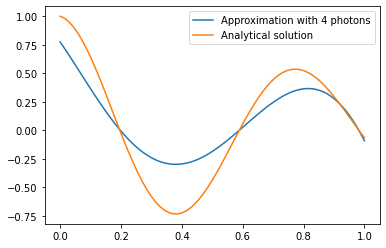

In [10]:
plot_solution(res.x, lambda_random)

Text(0, 0.5, 'Loss function value')

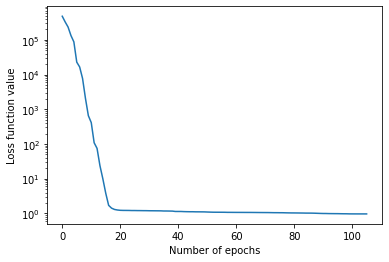

In [11]:
plt.plot(loss_evolution)
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")

### Comparison of the approximation in terms of photon number

We can also study how the the solutions which minimise the loss function for 3, 4, 5 and 6 photons converges towards the analytical solution.
We plot as well the loss function value as a function of the number of epochs (iterations) of Quantum Machine Learning.
We observe that a higher number of photons gives a more accurate approximate solution of the differential equation.

In [12]:
# dx = 1/1000
#n_grid = 50

params_200_3 = [-0.06356908,  0.08785208,  3.53487717,  0.98248241,  0.35934815, -3.80632453,
 -0.27596204,  0.94548853, -3.89595662,  0.68511975,  0.21457315, -1.08915504,
  0.27389283, -0.39444205, -0.57491981,  0.55123765, -2.09229711,  1.18847927,
 -1.30417531,  0.38326634,  2.81415235,  0.72979008, -0.03437252,  6.46866165,
 -0.24611543,  0.58936784,  1.06214265, -0.061367  , -0.02420861, -5.26749821,
 -1.11528585, -0.52320676, -0.70349191,  0.53454634,  1.56583728, -0.35151643]
loss_200_3 = [34455937.97114132, 660793.649681703, 632515.3174360733, 452514.340506456, 157621.6500666942, 67434.52062351831, 45132.47491300844, 28301.43592205269, 24662.27533848765, 17999.140304477416, 17200.315773948947, 16078.557533758634, 13964.775021666534, 6487.991710458712, 5545.210558827003, 2214.371216990552, 1976.4170032037534, 1626.3449619499045, 1277.0889281373757, 638.8080018370486, 447.55029142319506, 310.0344123607859, 269.4053009209827, 252.13944643182526, 224.06052794310318, 172.86801084671055, 143.55635122468522, 138.8477721161176, 130.07600469225292, 128.59213397774138, 83.30573589533235, 69.491184519188, 67.24480483570346, 63.93878360801212, 58.958088812452516, 57.15749200654439, 54.06095392303282, 48.64378707672029, 40.04422036849703, 37.42991238360701, 28.784737481072142, 27.485430327348972, 25.651771604078277, 24.124917588765264, 22.951642024416085, 21.176483766291135, 18.480034939736008, 17.01202562973208, 14.737424980916387, 11.536895837122023, 10.817535418841821, 10.273634989430276, 9.367451804630422, 8.159725971077753, 7.511153671986619, 6.930372838379077, 6.065205506949216, 5.62433961930448, 5.001485094529038, 4.334116272854462, 3.9955306592977804, 3.6685053455898546, 3.451653996532346, 3.3033261467650754, 3.127020736861133, 2.925891728983607, 2.6889182667258713, 2.451878458254666, 2.4144725141233523, 2.381782226775966, 2.3487637320592727, 2.3172461594855993, 2.2853166871369477, 2.2547646253501847, 2.227691238603895, 2.2039865817381146, 2.1862896331444905, 2.1423782407117846, 2.1189883962998706, 2.1145403642469556, 2.1040558299101635]
alpha_200_3 =  [193.89237306,  -82.3483232,    -3.15755067,  185.24290512,  128.92356187,
 -131.44562945,    5.37326308, -148.68600906,  193.43812247,   88.09018627]


params_200_4 = [ 0.14251674,  0.78048198,  0.18845674, -1.1715608,   0.16283426, -1.42025918,
 -1.1670349 ,  0.9977184 , -0.99793798,  0.8013819,   0.14907019,  2.2728529,
 -0.25805602,  1.04789297, -0.25765638, -1.39412223,  2.77559519,  1.06164693,
 -0.10608403,  0.04165775, -1.16619164, -1.37566153 ,-0.91091636,  0.96452239,
 -1.02632409, -0.18014476,  0.1165901 ,  1.74450203,  0.45210091,  1.74120727,
 -0.20065462 , 0.85640406, -0.3531761 , -0.59548248, -0.62972002, -3.33216578,
 -0.01331381, -0.82947899,  0.90537668, -0.16976383, -2.29755941, -0.08305495,
  1.00418469, -1.75617861, -1.29847323,  0.22867652,  2.36791296, -1.30371796,
 -0.3264172 ,  1.55408442,  1.21304659,  0.18173766,  0.75528927, -0.11447155,
  0.42302106, -0.44363647,  0.11000835,  0.11036822, -0.47028947, -0.1614167,
 -0.39696815, -2.8859638 ,  0.21780043,  0.01953443]
loss_200_4 = [350457.329066445, 22093.055866998915, 17701.17569871781, 10608.52827405731, 4536.64858044739, 1465.263840456495, 933.8505979163853, 258.9697358713163, 215.63406902434758, 134.30615812288713, 40.90704271861093, 9.641203771715839, 4.661471053746056, 2.424175656663811, 2.2720222012579097, 2.2506795545740927, 2.210935073524208, 2.163104555989432, 2.077652338606399, 1.9937295249754816, 1.9856788173306574, 1.9491302788258436, 1.8782354335906728, 1.856430765497904, 1.8518680309505937, 1.8496083964370098, 1.8393030106689192, 1.8109357879325063, 1.7721178899190715, 1.7659686315050234, 1.7618988804094116, 1.7510192750247535, 1.734045959248373, 1.7178968584841123, 1.710718365575631, 1.7014548187143308, 1.6892003227893893, 1.685806254512367, 1.6759424624710468, 1.6744211130222733, 1.658093102164235, 1.6544971537362547, 1.650190461220088, 1.6457800458801564, 1.6338508741650093, 1.6195468413024978, 1.619051180524571, 1.6067766232003091, 1.6039121132092955, 1.5632553089873082, 1.5608641392338414, 1.5600877048988222, 1.5527807615701383, 1.5511552360878824, 1.5501000873163608, 1.5490670012627257, 1.5131485528746191, 1.5115592806963714, 1.5103039936853784, 1.5051371181818687, 1.5017453142718367, 1.499556872041904, 1.4924738035247012, 1.4896352025461226, 1.471671182744092, 1.4674845422886056, 1.452466650619032, 1.4347625114634537, 1.4258570603256757, 1.3991304713345118, 1.3949795053687737, 1.3908168141423405, 1.3868078126511545, 1.3769973100799782, 1.3695123989361253, 1.3636775305761484, 1.3575400186728452, 1.32889347413765, 1.3273971315175805, 1.3264056312151427, 1.3208426460011569, 1.3177418373538026, 1.3140347615848667, 1.3093805985617317, 1.305237127838668, 1.3027782841018114, 1.3008282411746013, 1.299818739949782, 1.293818323866504, 1.2922261858649717, 1.2905147557738332, 1.2896716386572968, 1.2867733621768052, 1.2846373795622126, 1.2835652116835332, 1.2815915676137235, 1.2812831784065302, 1.280139192322952, 1.2799423403118564, 1.2776066190455184, 1.2768853153253639, 1.276843947529604, 1.2766207679821482]
alpha_200_4 = [-192.14937631,  -88.66598701,  -45.04100971, -105.94968842,  107.09475891,
   33.1550243 ,  108.65407474, -101.07434964,  -41.6671901 ,  130.60639613,
  115.42162089, -103.0762298 ,  137.28459864,  -68.61974718,  -50.05277672,
 -152.90715626,  112.13974717,  140.59851201,  -73.65852468,  -32.85401818,
  -30.96617209,   58.16292299, -128.23651979,  -44.40875066,  -49.01958254,
  134.81780666,  -32.86950223,   50.91078999,  157.3195513 , -117.03587523,
  189.55995839,  -24.09160068,  122.35647172, -163.42690834,  -60.63169887]


params_200_5 = [-1.46487108,  1.1784256 , -0.58643294, -2.53935452,  0.89372049,  1.54420227,
  0.11485261,  1.22132521, -2.10083214, -0.76641548, -2.4345932 , -1.17504696,
  2.9335011 , -0.16672108,  0.34310716, -2.89157231, -0.52521463,  1.27670392,
 -1.15693266,  0.58981988,  1.56698263,  0.1671329 , -1.83829146, -0.4487611,
  0.4901629 , -0.89320667, -0.78861307,  1.79414684,  0.42527228, -0.45201262,
  0.36258205, -1.01175175,  0.69420725, -0.14687074, -2.17137307,  2.07509689,
 -1.61870706, -2.10575434,  1.75942753,  0.2359455 , -0.89847821, -1.31869322,
  1.44600843,  2.60864781,  0.93437024, -1.57601238,  0.999754  ,  2.41669216,
 -0.55074948,  0.57442992,  0.60273763,  0.67166201,  0.18194417,  0.15066146,
  0.29131768, -1.0716886 , -0.3604123 , -0.13599533,  0.17064727, -0.26546635,
 -0.31463574,  0.19864103,  0.04389574,  1.58836506,  3.00695115, -1.06916747,
  0.68848185, -0.18417363,  0.27723179, -7.36438535,  0.02584663,  0.45353347,
 -0.08014111, -0.07297919, -4.8367172  ,-0.49806698,  0.24563759,  0.15718266,
  1.29828105,  0.82485945,  0.11398122 , 0.22641748, -0.53765172, -0.97908957,
  0.42565634, -0.10716891, -1.18177599,  0.7488578 ,  0.54486949, -4.9496316,
 -0.58642653,  1.71100895,  0.21633279,  0.22870638, -3.01265096,  0.49308179,
 -0.10831079,  0.90884221,  0.46096664, -2.87863504]
loss_200_5 = [131410.3461447966, 67329.24289525283, 23495.1897090863, 15702.932509979219, 7079.736099359005, 1960.338173598288, 1217.112496469443, 615.700726069746, 361.7130795480763, 40.691916266579746, 30.889021199375858, 24.276915428080738, 17.17758235233531, 15.394852367434934, 13.914181131395374, 13.280961273017866, 12.97937160368349, 10.221989758821408, 10.025347361941526, 9.66350558657789, 9.038926710287388, 8.243771059157709, 7.45846178732187, 5.969718393622559, 5.373473566711929, 4.165579980893719, 3.4449336718332693, 3.3093347780366953, 2.508365308307333, 2.148709034677296, 2.0000159127327364, 1.764133184764149, 1.566694989999001, 1.5401474889498694, 1.5075824483275069, 1.4960007815106615, 1.475813601581649, 1.4606324464623395, 1.4436755511937998, 1.4270055962603285, 1.422825458794778, 1.409117417561678, 1.407154390885217, 1.399605202785195, 1.3848865398980648, 1.3789982310528754, 1.373869891567846, 1.357658419988893, 1.324462022220723, 1.3086562314023147, 1.3037143500027366, 1.2264168923135503, 1.223858407997418, 1.2194058180477578, 1.2106719782451056, 1.2038588353901292, 1.198693575141035, 1.1797687882310175, 1.178316082031712, 1.153478034325662, 1.1387638891153413, 1.127932125793798, 1.1220556360197647, 1.1116188207634463, 1.0926195851849703, 1.0671858855008491, 1.0546482148792524, 1.047202327411852, 1.0356160147637863, 1.020462063389912, 1.0182432061945266, 1.0146902556967243, 1.0104898099846438, 1.0082732123837308, 0.9996838153203034, 0.9977248184529993, 0.9948681987904132, 0.990380287121157, 0.9852618154202153, 0.9768258991039724, 0.9745840276907366, 0.9707590759100607, 0.9684024124314048, 0.9648758338725807, 0.9625911907421206, 0.9602013213123659, 0.9586004390031073, 0.9506039968872283, 0.9495000214348539, 0.9421062325583368, 0.9410321702113349, 0.9379207500384804, 0.9370684713087087, 0.9343111925084593, 0.9332244877001608, 0.9308481908409247, 0.9305362710858841, 0.9300679783810442, 0.9263916495751566, 0.9235970933824421, 0.9215758723736173, 0.9199389578606325, 0.9176144690395402, 0.9148753732771402, 0.9125297030279822, 0.910955937983926, 0.9099025824111564, 0.9084601038271888, 0.9064304305546238, 0.9040707284388894, 0.9035902315442695, 0.9030680821281039, 0.8995068382251818, 0.8980416705699273, 0.89660177708201, 0.8950504333293202, 0.8931308755534453, 0.8912017433022942, 0.8887767253066342, 0.8877108581518341, 0.8865821140020342, 0.8832731775454957, 0.8824751210662477, 0.881382770124481, 0.8799443776518895, 0.8780650503558095, 0.8761234478571316, 0.8739278568695877, 0.8720668209235154, 0.8714727226524664, 0.870686628972695, 0.8695729844126382, 0.8684143767787498, 0.8682494606065919, 0.8670483267008926, 0.8661140203079235, 0.864987372980848, 0.8638264370674313, 0.8630299605564861, 0.8623584594348855, 0.8612799779943312, 0.8594910183059405, 0.8570956579359915, 0.8555921456461348, 0.8531659178455839, 0.849971614852831, 0.8442871303257202, 0.840158608291204, 0.8371897596832967, 0.8342458346957815, 0.8316651593823019, 0.830189978877099, 0.827513153169717, 0.8234712348072055, 0.8206339100480544, 0.8177746347671381, 0.8166016974628785, 0.8145440204259279, 0.8112274104262169, 0.8060007725602512, 0.8025869162063145, 0.7979663687227655, 0.797073816834135, 0.7959247056743399, 0.7943442239599844, 0.7928096395922715, 0.7910754129254416, 0.7891080966087928, 0.7868281568125343, 0.7863090113535425, 0.7857368502662253, 0.7850816207666084, 0.7843306163057457, 0.7834367743013412, 0.7823979971492062, 0.7810259557472189, 0.7802739601471135, 0.779673014483872, 0.7787755096958537, 0.7774991945613587, 0.7758158616655081, 0.774248388408141, 0.773714863285859, 0.77198071929594, 0.7715366167549551, 0.7707837389988309, 0.7695609686623989, 0.7648986296346402, 0.7632998577436051, 0.7605049154726544, 0.7587421060093152, 0.7560305141407089, 0.7508469593402494, 0.7416865559795381, 0.7333828433771543, 0.7303876107676907, 0.7253058271174588, 0.7226315099276641, 0.7183319002289851, 0.7148578380156405, 0.7101422015692458, 0.7063819060087255, 0.7009306975339038, 0.6981139850193329, 0.6939287196924768, 0.6880800636496289, 0.6847855881722154, 0.6805655800707061, 0.6773736706606621, 0.6760993453870638, 0.6742591767869115, 0.6712331758575147, 0.6669410243669357, 0.6652411290779702, 0.6647392525021983, 0.6594038833433403, 0.6584308062099575, 0.6569686510639317, 0.6545888353560543, 0.6508926467991557, 0.6466208675867976, 0.6448837379335945, 0.6421501377742167, 0.6407505228052895, 0.6383628964821089, 0.6344155694095951, 0.6280115995467531, 0.6246628436530508, 0.619731575388086, 0.6162768378861476, 0.6137469121241567, 0.6095320202315708, 0.6075108417833103, 0.6056112508663763, 0.6046976366639429, 0.6032773046021412, 0.5972639951565095, 0.593781002042321, 0.591300952234698, 0.589677901069535, 0.583438404605048, 0.5820653623337357, 0.5736624736823981, 0.5688971564563445, 0.5671220589304607, 0.5654139647292772, 0.5611904270846461, 0.5570124268818318, 0.5533204165902675, 0.5520740229011752, 0.5469112213165653, 0.5435568122912031, 0.5397718558176217, 0.538745979484149, 0.5358400104143999, 0.5329950294666057, 0.5323397187017735, 0.5319154801668818, 0.5315596123137467, 0.5299851216768444, 0.5293054243984908, 0.5269887254684091, 0.5266532145704597, 0.5264718544253593, 0.5257407746884477, 0.5227032246741247, 0.520420279940169, 0.5198861354086415, 0.5194659746225262, 0.5174342756600017, 0.5152710015037709, 0.5128543932011573, 0.510183138718382, 0.5074431476633912, 0.5046323963522747, 0.5036210212645151, 0.5028070439033199, 0.501990635822593, 0.4985353768515017, 0.495014650836462, 0.4924948970258443, 0.49210676599072684, 0.4902820544457453, 0.4899134385144946, 0.48967554441377636, 0.4888375015273488, 0.4879909794446122, 0.48651425696049955, 0.48635964094130896, 0.4859757460899317, 0.48538176178874354, 0.4838834918246067, 0.4838743368622187, 0.4806699937083373, 0.478318613735946, 0.47805504345261873, 0.4779224855851959, 0.4774786894274067, 0.4762971218757781, 0.47565706631150123, 0.4756477690199103, 0.47536256633392704, 0.474224334470641, 0.473693764442763, 0.4721697441267405, 0.47147034977631236, 0.47133230508972096]
alpha_200_5 = [   6.67475324, -125.29801647, -167.82333543,   -6.94881003, -195.66353645,
  -49.11628905,  121.05667405,    1.78157444,   78.24931324,  193.85694149,
 -112.53057413, -197.73636563,  173.4542454 ,  159.72719785,  -77.84819208,
 -102.60378879,  167.98974857,  -78.43387499,   -4.99889537,  103.60483401,
  183.12471489,  136.72449374, -174.38551819, -148.96652962,   38.79278912,
   18.00557211,  120.65480348,  177.44470137,   38.7692071 ,   95.87771229,
   37.66291903, -179.2956463 ,  -65.12333175,   38.63161436, -182.67770649,
  -82.6194007 ,   80.65525231,  -87.20664383, -174.45685837, -172.85020201,
   83.86745545, -170.29557031,  150.31077156, -115.65276082,  -19.06769879,
  136.60072442,  187.69185486,   16.31457125, -132.2157452 , -178.42967446,
   69.83331139,  194.29435511,  -70.27987225,   13.70925476,  195.98664221,
 -150.58515799,  143.45931604,  162.1191406  , -12.4534154 , -121.81386114,
  103.98691509,   36.06739274,  172.01754023 , 186.74319434,  -89.90062932,
   79.26689465 ,  14.04057746,  -39.82129031,  136.9464721 ,    3.2396841,
   97.52861253 ,-113.13044136,  120.36426194, -183.44403825,   93.63041518,
  121.45163094 ,-129.05291227,   81.58129451, -164.88571387,  194.71398372,
 -153.88851076, -180.7893567 , -105.47116525,  195.60594901, -122.45980554,
  -75.55937386,   65.7850577 ,  119.08769593,  122.29378214, -109.12776373,
  -45.14114309,  -64.36751891,  149.83363935,   13.859606  ,   -3.10795186,
  118.80765851,   59.68455038,   69.63774767 , 152.14137901,   -4.11859856,
   88.37948351,  -75.50247958,  140.86499118,   65.18444968, -185.92051327,
 -121.87914032,  121.53232188,  173.82610178 , 132.56749486,  -20.39582386,
  -40.80777932, -156.91091647,  149.97904725, -171.08614324,  199.81578734,
   86.87875502,  -41.77850549,   -4.37382893, -177.0566759 ,  -27.50674512,
   92.48354378,   31.96020654,  107.44901282,   43.47835471, -108.73267396,
  164.59422159]


loss_200_6 = [257670.75749469252, 30459.17728251494, 19991.81691794082, 17235.00402993676, 13012.604105388149, 6438.406115418616, 5722.352910567919, 596.3647729005565, 525.8151468813488, 68.86795500913075, 31.81635287130011, 16.925435102012585, 11.15347322373911, 7.463564736715714, 7.272993146421325, 6.915358893192453, 6.230559304371486, 5.502033659262459, 4.684342441864529, 4.573006201086299, 4.390943257082712, 3.0762458239734825, 2.7555713244056688, 2.5760327710006896, 2.511113883844013, 2.400315974063136, 2.1886000567817665, 2.0659102205274915, 1.8551979801010605, 1.7412970273134667, 1.5719075197577324, 1.4188598441755704, 1.2416696048168963, 1.1703964837134309, 1.1283003191541165, 1.0935324834682094, 1.0776601286598737, 1.0613112357913759, 1.0461836776145597, 1.0349037137390917, 1.0310755711388322, 1.0262108829149064, 1.0241676396541637, 1.0221129712495753, 1.0089310286024016, 1.0055548564307308, 0.9889972572031787, 0.9810108452280505, 0.9626082769475783, 0.960242129617513, 0.9280018992215784, 0.9155995135790372, 0.9092921681075985, 0.8984523415953066, 0.8945113692021099, 0.8874297866713176, 0.8783709858745303, 0.8747039454482461, 0.8610059352410453, 0.855711371709492, 0.8493297574247067, 0.8393082056342882, 0.8284710236098902, 0.8207131194356978, 0.8102093761250407, 0.803356349127969, 0.7948688744249561, 0.765195840722534, 0.7634708461209998, 0.7606808913347565, 0.7571259486390042, 0.7428463774658421, 0.7350340089404195, 0.7138460860153895, 0.7098920301497497, 0.7042027946363134, 0.7028853251622155, 0.7028662177080536, 0.7021217230361106, 0.6984300964545624, 0.6960960412039968, 0.6944430072440975, 0.6861286394903208, 0.6845604277138263, 0.6776125674728075, 0.6772680130652619, 0.6767625573320637, 0.6763973465169713, 0.6734543457977219, 0.6719705024452644, 0.669246101014175, 0.6648083177914059, 0.662190352007029, 0.6521485384809259, 0.6376578044704467, 0.6257119652328997, 0.6174373792886273, 0.6139213289403568, 0.6116588357526269, 0.6094520491354466, 0.6052862940586917, 0.5989188389023599, 0.5907334558970299, 0.5500232145817892, 0.5442995205877942, 0.5419649505936669, 0.5390937129571959, 0.5355822806096378, 0.5299052982966975, 0.5267891075947886, 0.5216675481876863, 0.5123837137914299, 0.5020240952528118, 0.48147389424992826, 0.47316396073693845, 0.45981068984196477, 0.4422196510757847, 0.4393597719031403, 0.437129459622929, 0.43330491209219063, 0.4302799718695677, 0.42500364490841497, 0.4151973543062281, 0.4076457019885883, 0.395823331012063, 0.3906081194384803, 0.371394180003866, 0.368269970359524, 0.3483279487795562, 0.33622444549092934, 0.32948953137293524, 0.32403527992317743, 0.32213741997176376, 0.31884870536906157, 0.3128377531349079, 0.30562969606677837, 0.2905232041865022, 0.28681661656308605, 0.28462968642356085, 0.27524727718522407, 0.2726535365425401, 0.2607444364234378, 0.257458760766291, 0.25497268927542727, 0.24173984189628814, 0.239814529273876, 0.23729734148280313, 0.23330476620632776, 0.23050587135429532, 0.22664124825834278, 0.21969713064907948, 0.208594465572458, 0.20020361638361656, 0.1950791912251191, 0.1900782905933373, 0.18598508239402364, 0.18151632434206255, 0.17446444561447133, 0.17331317590812745, 0.1646123253732648, 0.1612130642829983, 0.15913962585903751, 0.15806056311952715, 0.15658312723515272, 0.1542182832192492, 0.1467761161015561, 0.14549341546600447, 0.14394915396813876, 0.14167910980722953, 0.1390807621303284, 0.13821184796435546, 0.13720454962173134, 0.1360026966002736, 0.13190874129418545, 0.13086992209287052, 0.12880196399661253, 0.12856235670014274, 0.12747306541756884, 0.12512470550675747, 0.12416067020489394, 0.12326898821697531, 0.12271538945757443, 0.11994998391506304, 0.11924707596001374, 0.11822252499375957, 0.11785272255020182, 0.11644525973905032, 0.11537155904377915, 0.1145145727329029, 0.11311384193348031, 0.10929045364342387, 0.10795474176762988, 0.10611134354715436, 0.10427403121330961, 0.10100167126292796, 0.10002688541340887, 0.09911698619944817, 0.0957301262634632, 0.09465595773314554, 0.09385287294574779, 0.0927601525625275, 0.0895335548673514, 0.08713594301485754, 0.08609149497402135, 0.08501321923009707, 0.08073927278959077, 0.07676870722233922, 0.07628607130292886, 0.0758477798300733, 0.07529710363958021, 0.07347594513868257, 0.07096999972961573, 0.0704944168062992, 0.06925707134638749, 0.06824328782329539, 0.06567163361253664, 0.06336374016002255, 0.06231239582493142, 0.06163519441723933, 0.060780607936265565, 0.05609761103729422, 0.052853626139302216, 0.05209647708561763, 0.05151800318391673, 0.05092382291913353, 0.04965653858225006, 0.048488936487617255, 0.047280385617140375, 0.046256832952153104, 0.04508083151332867, 0.043973820228917465, 0.03921671543171772, 0.03809697054324323, 0.03716545420644815, 0.03625422798719244, 0.03524642411016848, 0.034197823406825076, 0.03306226293968647, 0.03208952462618879, 0.031032756476711908, 0.029779934153324677, 0.02814993354001882, 0.026300316988035814, 0.02439123874260529, 0.023578669557479146, 0.02253642175362468, 0.021078086217592874, 0.019174794367820925, 0.01784417439044547, 0.017625143094770784, 0.016230708346067865, 0.014163091923127645, 0.013078796270452235, 0.012463082130919213, 0.01187408874552798, 0.011773337794389287, 0.011422131809484084, 0.01106052359682138, 0.010786711238183698, 0.01066263033340474, 0.010205011540653897, 0.009922951075835924, 0.009837435290020537, 0.00968548509758985, 0.009611468058426987, 0.009607234445587757]
params_200_6 = array([ -1.17583181, -1.49577889, -1.69813193, -0.5392364 ,  0.46867106, -0.54890015,
  0.43622208, -0.01203605, -0.07055389, -1.06923605,  1.461852  , -0.34288577,
 -0.36608723,  1.33892325, -0.31950692, -0.38549877, -1.05427033, -0.06189988,
 -1.2858778 , -2.08796022,  0.62701417,  0.51809314,  1.35359869, -0.40915285,
 -1.109356  , -2.32784116, -0.83527732,  0.4767799 , -0.94944948 , 0.64789004,
  1.17998656,  0.49232933,  2.08008716,  0.91382149, -1.58551043, -0.47251962,
  0.83445887,  1.28777264,  0.98425552,  0.85525042, -2.33880244, -1.46330306,
  1.55357203,  1.14684172,  1.13696055,  0.29148597,  0.70568304, -0.12664236,
  0.41573463 ,-1.0929248 , -0.06421914,  1.22425084,  0.9663121  , 0.58973943,
 -0.90963929 ,-0.52224961,  0.77631702,  0.83030775, -1.85060113,  0.67227936,
  1.87274098, -0.51618261, -0.37068709,  1.89795287, -0.84745613,  1.16452425,
  0.22234936,  0.82786738, -0.13714029,  0.21657197, -1.66479636, -0.16955006,
  0.72069802,  0.57512481,  0.43186722,  0.56213305, -0.72936753,  0.40137452,
 -0.40285887, -0.09127116,  0.34862264, -1.38374572, -0.20931097,  0.02396482,
  0.53117859, -0.00763969, -0.47377112, -1.01661275,  0.55920927,  2.13406481,
 -1.14371653,  1.10503269,  0.47919379,  0.52509376, -0.50347124, -0.89952841,
 -0.88454469, -0.45253695, -1.92018041 ,-1.36687251, -1.11347797, -0.58632635,
  0.16569378, -2.35944726, -0.81686003 ,-0.64999615, -1.39251997, -1.7918698,
 -0.50660286,  2.07457464,  0.01228415, -0.1661133 , -0.43581628,  0.58069291,
 -0.07549375,  0.17767723, -0.98385125, -0.05886299,  0.75303892,  0.22424766,
 -0.63797683, -1.18904657,  2.15890184, -0.07976867,  1.5982913 ,  1.22454668,
 -0.16524297,  1.36586012, -2.00871645, -2.21036094, -0.85730845, -0.30223156,
  1.13141483,  1.56570876, -2.13649418,  0.19985919,  1.20182291, -0.20559492,
  0.09810261,  0.19664353, -2.9361866 ,  3.98296807 , 0.17592328,  0.05709268])
alpha_200_6 = array([-153.08414105,  -47.44341044,  175.77605138,  111.58283147,  -52.55472262,
  -55.28646901,  -35.4130926 ,   57.83125984,  -26.39888527,  -57.24448536,
  188.1807248  ,-102.02068188,   41.50653462,  -11.6718509 , -130.66216364,
  152.00125501,   29.00897473,  -73.54722502,   72.19071007,  192.94173087,
   26.89538297,   91.04557912, -197.80856332,  103.76183847,  -68.8726426,
   84.3384335 ,   70.19413494,  -91.1064587 ,  -22.9430042 ,  -39.6998754,
 -101.07920391,   31.35748178,   24.41948376,  -43.72805803,    5.53778457,
  -36.92164005, -158.1669372 , -170.93225218,  167.42064756, -106.02153919,
 -171.30492729, -178.1572779 , -145.79943828,  -59.12689406,  -54.89390088,
  -34.16802508,  -23.69371401,  196.02093135,  112.30580876,  -71.05713781,
  -32.64314649,  -37.45576666,  -29.60032987,   78.71449103, -100.58513118,
  169.62341581, -114.64858377,  -86.10746891,   73.65353729, -108.84698999,
  161.62388778,   45.71284708,  -11.27769278,   -1.38581343,  -10.70777141,
  105.9039969 ,  -20.27958348,   22.29695272,  181.53759139,  -53.7187006,
  157.33678534, -173.7856809 ,   11.06774439,   -3.27638915, -157.55871806,
   42.70592407, -197.67408869,  114.74982096,  185.48125283, -162.23486614,
   -5.0126685 ,   58.06577645,  141.92241793,   55.21623395, -151.90792096,
  179.63396244, -198.4683798  ,  76.34608137,   -6.84562339, -184.68600565,
  136.4407315 ,   36.66793045 , 179.35202487, -145.38289165,   76.80079948,
  168.7919152 ,   72.98370027,   77.31002959,   18.47588965,  -30.89667661,
 -197.35181111,   53.60394381, -174.53655865,  -43.89942956,  189.99676639,
   58.97362287,  -16.66519001,  198.95273201, -118.74310604,  -23.4524723,
 -117.43759729,  112.93591621, -120.39096693, -168.11169138,  188.52544657,
 -101.22350714,   63.56472737,   40.93487174,   79.56216552,   16.10395967,
   72.7857287 ,  109.68674213, -174.63998226,  -53.83664158 ,-163.14696652,
 -132.6503988 ,  -48.93046422, -141.76811888,  193.23860629,   13.65026122,
  -11.67584978,   41.67724107,   19.70221268,   36.81416509,  188.7248892,
 -153.20328177,   48.80194381,  108.77080689,   27.58224944,   35.32567696,
  137.13924289, -128.85533587, -177.73727536, -120.0008216 ,   82.35645085,
  -22.65907042,  -25.64517422,  149.31127276,   58.43278002, -189.67071703,
  -70.46609703, -170.32920118,  110.06841503,  -10.09937453,   42.65536115,
  133.19350227,  175.58216458,  -33.30803458,  -88.90895606,  104.04993338,
  -60.66261148,  -83.66266925,   70.7290364 ,    3.20056249, -144.86814525,
  151.43134284,  -10.32795366,  -25.00672491,   -5.2386131 ,   -6.48473584,
  103.79070096,   50.43593853,   -6.8190554 ,  170.48978367,  144.08468786,
 -187.42741676,   53.74661987, -143.7341344 , -149.49862587,  187.93777346,
  -69.05142518,  -63.00177824,  -76.76578753,  -47.15861321, -159.24241962,
  132.51256644,   83.23006539, -137.35729507, -195.14965008,  -78.82612921,
   45.72326625,  -61.84552029, -182.74540862, -117.62627133, -132.4946625,
 -133.29244544,  -52.22284673,   10.68080639, -166.87854602, -165.852919,
   51.16693625,   24.18187512,  -95.25363075, -128.52574965,  129.42542566,
  151.05504365,  131.2497635 ,  127.17745989, -157.72074769,  109.65633474,
  179.77276195, -127.35969104,   63.60176161,  106.3377048 , -189.95450107,
  -61.92850327, -159.45765425,  183.50672138, -191.64692117,  -48.36783763,
 -145.74877204, -120.08736166, -109.83800018,  131.85871725,   26.97205925,
 -138.62013626,   44.91739293, -105.85027325,  -81.48760602,  159.52011678,
   84.87099429,  184.98071473,  103.25917796, -178.35323127,  116.54280792,
  -71.50274864, -136.05089721,   88.79072567, -152.07393731,  164.52505024,
  100.99162458,  167.99376583,   92.10229174,   54.01682195, -175.50557998,
   27.02525884, -109.97431224,  109.97346223,   49.5172246 ,   77.10576871,
 -144.65898661,   77.13531345, -191.16826041,  -69.35892033,  189.49067614,
  -99.49492203,  144.70333764, -137.93635496,  -70.65548507, -186.42381889,
  -40.74102336,   54.16620489,   79.91577046, -198.76952509,   77.86378628,
  194.57420475,  130.72485134, -112.60070986,   69.60595208,  -27.25997157,
   59.49134337,   26.37331883, -139.80885916,   86.26867181, -124.88312129,
 -152.32654073, -105.33972633, -160.81553495, -171.47973249, -112.77589177,
 -110.05920014,  -64.0530868 ,  197.05238513,  -75.07989386,  -87.38337781,
  -34.39346997,  -41.50791865, -196.63250625, -175.7131448 , -132.74767487,
  129.25248202,   37.43286667,   46.69926539,  135.98247695,  181.15137602,
   83.01483613,  -58.92483376,  141.08604653,  131.46439351,  159.88187085,
  187.5960506 , -103.94697487,   41.81537992, -180.09381226,   47.44740478,
 -157.47488381, -131.74687996 , -84.67117138,   41.45051    ,  38.74640304,
 -198.11440233,   10.67601863,  -64.64017672,  -40.28756929, -126.92661019,
 -122.68871204,   14.94129196, -150.94314582,  127.42908059, -143.2559051,
  171.91890622,  152.10463491, -163.75984621,  -22.86914371,  -71.84964719,
  182.78288197, -196.49329726,  -47.64625232,   96.1995464 ,   28.96734335,
  -49.39827885,  141.98020117, -172.45541108,   48.60610496,  -82.56061646,
   44.41672481,    1.62865578, -107.08104099,  -43.87306819, -167.78157378,
  -51.24063618, -145.04420335, -170.53692481,   65.17295185, -190.39093608,
  122.13352758,   81.14836219,  -42.98257424,  -90.32103298, -114.11673023,
 -199.46463805,   92.23708476,  -24.44989192,   27.76301804,   82.89072235,
  -67.19466238,   70.67540505, -125.5518367 ,   39.37117797,   58.629548,
 -191.3019376 , -154.37393227,  -71.86572211,  -73.94457258,   -6.59174924,
   22.47065033, -165.52212088,  143.72380907, -103.62656074,  103.45916908,
   92.89517564, -176.65400949,  -61.54811595, -118.11077657,  -81.76614456,
  -61.73089591,  -26.9847177 ,    8.31324202,  174.71837068,   74.17130681,
  189.09650953,  -49.56536469,  193.03509269,  -56.91274001, -138.59467855,
   89.45304531,  131.87995051, -118.57439999,  181.44695581, -117.25732307,
 -106.0233514 , -101.33144856,   74.41991123,  -83.26248804,  -68.71812159,
  -76.03809002,  -47.17476971, -161.37610035,   10.81459742, -193.61346563,
 -121.73069282, -140.47082891,   36.84836546, -132.14098876 , 133.09479485,
   -1.18718343,  163.45915083, -137.86953868,  -87.72574537,  158.53525399,
  120.57977696,  -63.10315759,  109.2300741 , -125.79438755,  -67.42876457,
  107.89283543,  -91.69993008,   49.03984236,  107.44927052,  193.39391583,
 -192.18880936,   82.12635429, -126.98890062, -184.461637  ,   25.22688831,
 -172.5427563 ,   -7.7665082 ,  182.60460992,   10.55826299,  -86.4151586,
 -114.81236939,  169.5824903 ,  191.5402745 ,  175.05788952,   33.90685458,
  107.12691824,  179.32079178,  -78.81778063,  111.1051572 ,  123.9237772,
   58.23512864,   88.46819075,  -24.00790567,  116.43330719, -111.14632908,
 -118.52951927,   59.89130946,   49.71859903,  134.67705005, -197.1952264,
 -122.54108465, -136.31863178,  -30.06806649,  -49.93967227,   80.4772987,
  137.95478631, -196.67040697,  179.90171968, -153.62776602 ,-153.21039278,
   27.69775526,  165.63715798])

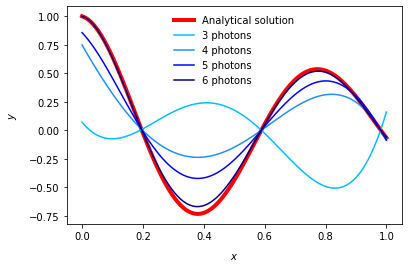

In [13]:
X = np.linspace(0, 1, 100)
exact = u(X)


def return_solution(optim_param, alpha_random, nx=100):
    input_state = pcvl.BasicState(input)
    Y = []
    U_1 = qr_haar(optim_param[:2 * m ** 2], m)
    U_2 = qr_haar(optim_param[2 * m ** 2:], m)
    simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
    for x in X:
        i = 0
        f_theta = 0
        phase_shift_ = phase_shift(m, x)
        U = matmul(U_2, phase_shift_)
        U = matmul(U, U_1)
        # which simulator we are using
        s1 = simulator_backend(pcvl.Matrix(U))
        for(output,prob_output) in s1.allstateprob_iterator(input_state):
            f_theta += prob_output * alpha_random[i]
            i += 1
        Y.append(f_theta)
    return Y

N=3
m=3
photon = np.ones(N)
non_photon = np.zeros(m - N)
input = np.concatenate((photon, non_photon))
input = np.array(input, dtype=int)
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters =np.random.normal(size=4*m**2)
photon_3 = return_solution(params_200_3, alpha_200_3)

N=4
m=4
photon = np.ones(N)
non_photon = np.zeros(m - N)
input = np.concatenate((photon, non_photon))
input = np.array(input, dtype=int)
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters =np.random.normal(size=4*m**2)
photon_4 = return_solution(params_200_4, alpha_200_4)

N=5
m=5
photon = np.ones(N)
non_photon = np.zeros(m - N)
input = np.concatenate((photon, non_photon))
input = np.array(input, dtype=int)
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters =np.random.normal(size=4*m**2)
photon_5 = return_solution(params_200_5, alpha_200_5)

N=6
m=6
photon = np.ones(N)
non_photon = np.zeros(m - N)
input = np.concatenate((photon, non_photon))
input = np.array(input, dtype=int)
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters =np.random.normal(size=4*m**2)
photon_6 = return_solution(params_200_6, alpha_200_6)

plt.plot(X,exact, 'r', label = 'Analytical solution', linewidth = 4)
plt.plot(X, photon_3, color='deepskyblue', label = "3 photons")
plt.plot(X, photon_4, color='dodgerblue', label = "4 photons")
plt.plot(X, photon_5, color='blue',  label = "5 photons")
plt.plot(X, photon_6, color='darkblue', label = "6 photons")
plt.xlabel('$x$', labelpad = 10)
plt.ylabel('$y$', labelpad = 10)
plt.legend(frameon=False, fontsize = 10)
plt.show()

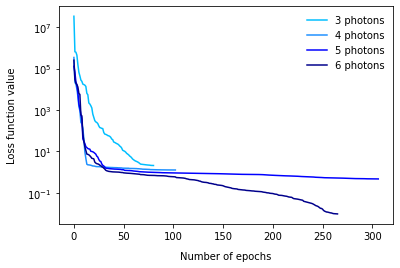

In [14]:
plt.plot(loss_200_3, color='deepskyblue',  label = "3 photons")
plt.plot(loss_200_4, color='dodgerblue', label = "4 photons")
plt.plot(loss_200_5, color='blue', label = "5 photons")
plt.plot(loss_200_6, color='darkblue', label = "6 photons")
plt.yscale('log')
plt.xlabel('Number of epochs', labelpad = 10)
plt.ylabel('Loss function value', labelpad = 10)
plt.legend(frameon=False, fontsize = 10)
plt.show()

## References

\[1\] : O. Kyriienko, A. E. Paine, and V. E. Elfving, “Solving nonlinear differential equations with differentiable quantum circuits”, *Physical Review A* **103**, 052416 (2021). https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.052416

\[2\] A. Pérez-Salinas, A. Cervera-Lierta, E. Gil-Fuster, and J. I. Latorre, “Data re-uploading for a universal quantum classifier”, *Quantum* **4**, 226 (2020). https://quantum-journal.org/papers/q-2020-02-06-226/

\[3\] M. Schuld, R. Sweke, and J. J. Meyer, “Effect of data encoding on the expressive power of variational quantum-machine-learning models”, *Physical Review A* **103**, 032430 (2021). https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.032430

\[4\] B. Y. Gan, D. Leykam, D. G. Angelakis, and D. G. Angelakis, “Fock State-enhanced Expressivity of Quantum Machine Learning Models”, in *Conference on Lasers andElectro-Optics* (2021), paper JW1A.73. Optica Publishing Group, (2021). https://opg.optica.org/abstract.cfm?uri=CLEO_AT-2021-JW1A.73.

\[5\] R. Fletcher, Practical methods of optimization. John Wiley & Sons. (2013) https://onlinelibrary.wiley.com/doi/book/10.1002/9781118723203